In [1]:
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sys
sys.path.append("../") # <-- Path to the DRL4AMM repo

from DRL4AMM.gym.AvellanedaStoikovEnvironment import AvellanedaStoikovEnvironment
from DRL4AMM.rewards.RewardFunctions import PnL, CJ_criterion

from DRL4AMM.tile_coding.tile_coding import *

In [2]:
terminal_time = 1.0
n_steps = 100
arrival_rate = 50.0
reward_function = CJ_criterion()
timestamps = np.linspace(0, terminal_time, n_steps + 1)
env_params = dict(terminal_time=terminal_time, n_steps=n_steps, arrival_rate=arrival_rate, reward_function=reward_function)
env = AvellanedaStoikovEnvironment(**env_params)

from DRL4AMM.gym.wrappers import *
reduced_env = ReduceStateSizeWrapper(env)



In [3]:
# Stock price, Cash, Inventory, Time left

#print("Action Space {}".format(env.action_space))
#print("State Space {}".format(env.observation_space))

In [4]:
# First create our tilings

feature_ranges = [[lb,ub] for lb,ub in zip(list(env.observation_space.low), list(env.observation_space.high))]  
number_tilings = 1
n_bins = 5
bins = [[n_bins] * 4]  
offsets = [[0, 0, 0, 0]]
tilings = create_tilings(feature_ranges, number_tilings, bins, offsets)
print(tilings.shape)  # # of tilings X features X bins

(1, 4, 4)


In [5]:
# First create our tilings

#feature_ranges = [[lb,ub] for lb,ub in zip(list(env.observation_space.low), list(env.observation_space.high))]  
#number_tilings = 3
#bins = [[10, 10, 10, 10], [10, 10, 10, 10], [10, 10, 10, 10]]  # each tiling has a 10*10*10*10 grid
#offsets = [[0, 0, 0, 0], [10, 1000, 10, 0.1], [20, 2000, 20, 0.2]]
#tilings = create_tilings(feature_ranges, number_tilings, bins, offsets)
#print(tilings.shape)  # # of tilings X features X bins

In [6]:
def get_action_space():
        
    from itertools import product

    base1 = np.arange(0,0.25,0.005)
    base2 = np.arange(0,0.25,0.005)
    action_space = np.array(list(product(*[base1, base2])),dtype='float32')
    action_space = list(action_space)
    
    return [tuple(a) for a in action_space]

In [7]:
action_space = get_action_space()
q = QValueFunction(tilings, action_space, lr = 0.1, gamma = 0.99, eps = 1)

In [33]:
from tqdm import tqdm

N_STEPS = 5000

new_state = list(env.reset())

# arbitrary first action
action = action_space[0]

keep_rewards = []
keep_actions = []
keep_episodic_rewards = []

episodic_reward = 0

q.eps = 1

for i in tqdm(range(N_STEPS)):
    
    # take the new action
    new = env.step(action)
    
    # new state and collected reward
    old_state = new_state
    new_state = list(new[0])
    reward = new[1]
    done = new[2]

    # increment episodic reward
    episodic_reward += reward
    
    if done:
        keep_episodic_rewards.append(episodic_reward)
        #print("Episodic reward", episodic_reward)
        
        # reset episodic reward
        episodic_reward = 0
        new_state = list(env.reset())
    
    else:
    
        # create Q target
        target = q.get_target(reward, new_state)
    
        # perform Q update
        q.update(old_state, action, target)
    
        # select new action based on new state
        action = q.eps_greedy(new_state)
    
            
    # shrink eps
    q.eps *= 0.999
    
    # keep reward and action
    keep_rewards.append(reward)
    keep_actions.append(action)
    
    if i % 100 == 0:    
        print("Iteration: %s, eps: %s" % (i, q.eps))
        #rewards = pd.Series(keep_rewards)
        #print(rewards.rolling(100).mean().tail(1))

  0%|                                                                             | 1/5000 [00:00<24:33,  3.39it/s]

Iteration: 0, eps: 0.999


  2%|█▌                                                                         | 101/5000 [00:27<20:28,  3.99it/s]

Iteration: 100, eps: 0.9038873549665959


  4%|███                                                                        | 201/5000 [00:58<21:35,  3.70it/s]

Iteration: 200, eps: 0.8178301806491574


  6%|████▌                                                                      | 301/5000 [01:30<19:59,  3.92it/s]

Iteration: 300, eps: 0.7399663251239436


  8%|██████                                                                     | 401/5000 [02:06<15:02,  5.10it/s]

Iteration: 400, eps: 0.6695157201007336


 10%|███████▌                                                                   | 501/5000 [02:47<32:25,  2.31it/s]

Iteration: 500, eps: 0.6057725659163237


 12%|█████████                                                                  | 601/5000 [03:27<18:36,  3.94it/s]

Iteration: 600, eps: 0.548098260578011


 14%|██████████▌                                                                | 701/5000 [04:07<21:24,  3.35it/s]

Iteration: 700, eps: 0.4959150020176678


 16%|████████████                                                               | 801/5000 [04:48<16:12,  4.32it/s]

Iteration: 800, eps: 0.44869999946146477


 18%|█████████████▌                                                             | 901/5000 [05:31<23:26,  2.91it/s]

Iteration: 900, eps: 0.4059802359226587


 20%|██████████████▊                                                           | 1001/5000 [06:16<18:52,  3.53it/s]

Iteration: 1000, eps: 0.36732772934619257


 22%|████████████████▎                                                         | 1101/5000 [06:58<21:18,  3.05it/s]

Iteration: 1100, eps: 0.33235524492954527


 24%|█████████████████▊                                                        | 1201/5000 [07:45<25:45,  2.46it/s]

Iteration: 1200, eps: 0.3007124156643058


 26%|███████████████████▎                                                      | 1301/5000 [08:28<22:03,  2.80it/s]

Iteration: 1300, eps: 0.2720822322326576


 28%|████████████████████▋                                                     | 1402/5000 [09:17<21:10,  2.83it/s]

Iteration: 1400, eps: 0.2461778670932771


 30%|██████████████████████▏                                                   | 1502/5000 [10:02<23:30,  2.48it/s]

Iteration: 1500, eps: 0.22273980093919937


 32%|███████████████████████▋                                                  | 1601/5000 [10:46<21:30,  2.63it/s]

Iteration: 1600, eps: 0.2015332227394583


 34%|█████████████████████████▏                                                | 1701/5000 [11:34<16:57,  3.24it/s]

Iteration: 1700, eps: 0.18234567731717977


 36%|██████████████████████████▋                                               | 1802/5000 [12:21<21:00,  2.54it/s]

Iteration: 1800, eps: 0.1649849368967147


 38%|████████████████████████████▏                                             | 1901/5000 [13:07<19:30,  2.65it/s]

Iteration: 1900, eps: 0.14927707529619813


 40%|█████████████████████████████▌                                            | 2001/5000 [16:01<56:38,  1.13s/it]

Iteration: 2000, eps: 0.13506472547210188


 42%|███████████████████████████████                                           | 2101/5000 [16:54<15:55,  3.03it/s]

Iteration: 2100, eps: 0.12220550295922675


 44%|████████████████████████████████▌                                         | 2201/5000 [17:49<15:58,  2.92it/s]

Iteration: 2200, eps: 0.11057057941158951


 46%|██████████████████████████████████                                        | 2301/5000 [18:44<17:40,  2.55it/s]

Iteration: 2300, eps: 0.10004339195341891


 48%|███████████████████████████████████▌                                      | 2401/5000 [19:42<16:56,  2.56it/s]

Iteration: 2400, eps: 0.09051847541007228


 50%|█████████████████████████████████████                                     | 2501/5000 [20:33<15:15,  2.73it/s]

Iteration: 2500, eps: 0.08190040571973876


 52%|██████████████████████████████████████▍                                   | 2601/5000 [21:21<15:14,  2.62it/s]

Iteration: 2600, eps: 0.07410284394064628


 54%|███████████████████████████████████████▉                                  | 2701/5000 [22:23<14:50,  2.58it/s]

Iteration: 2700, eps: 0.06704767127628951


 56%|█████████████████████████████████████████▍                                | 2801/5000 [23:13<14:08,  2.59it/s]

Iteration: 2800, eps: 0.060664206453048174


 58%|██████████████████████████████████████████▉                               | 2901/5000 [24:14<14:51,  2.35it/s]

Iteration: 2900, eps: 0.05488849760960279


 60%|████████████████████████████████████████████▍                             | 3001/5000 [25:18<14:00,  2.38it/s]

Iteration: 3000, eps: 0.049662681604038215


 62%|█████████████████████████████████████████████▉                            | 3101/5000 [26:08<12:01,  2.63it/s]

Iteration: 3100, eps: 0.04493440431994225


 64%|███████████████████████████████████████████████▍                          | 3202/5000 [27:03<11:11,  2.68it/s]

Iteration: 3200, eps: 0.04065629616391608


 66%|████████████████████████████████████████████████▊                         | 3301/5000 [28:02<17:05,  1.66it/s]

Iteration: 3300, eps: 0.03678549749984046


 68%|██████████████████████████████████████████████████▎                       | 3401/5000 [28:57<09:30,  2.80it/s]

Iteration: 3400, eps: 0.03328322926552661


 70%|███████████████████████████████████████████████████▊                      | 3501/5000 [29:47<10:35,  2.36it/s]

Iteration: 3500, eps: 0.030114404470033673


 72%|█████████████████████████████████████████████████████▎                    | 3601/5000 [30:41<11:54,  1.96it/s]

Iteration: 3600, eps: 0.027247276679492435


 74%|██████████████████████████████████████████████████████▊                   | 3701/5000 [31:41<11:22,  1.90it/s]

Iteration: 3700, eps: 0.024653121969839265


 76%|████████████████████████████████████████████████████████▎                 | 3801/5000 [32:44<10:22,  1.93it/s]

Iteration: 3800, eps: 0.022305951160147018


 78%|█████████████████████████████████████████████████████████▋                | 3901/5000 [33:50<10:04,  1.82it/s]

Iteration: 3900, eps: 0.02018224944360293


 80%|███████████████████████████████████████████████████████████▏              | 4001/5000 [34:51<06:33,  2.54it/s]

Iteration: 4000, eps: 0.018260740807661956


 82%|████████████████████████████████████████████████████████████▋             | 4101/5000 [35:47<06:03,  2.48it/s]

Iteration: 4100, eps: 0.016522174883251375


 84%|██████████████████████████████████████████████████████████████▏           | 4201/5000 [36:36<04:57,  2.69it/s]

Iteration: 4200, eps: 0.014949134087605212


 86%|███████████████████████████████████████████████████████████████▋          | 4301/5000 [37:27<05:58,  1.95it/s]

Iteration: 4300, eps: 0.01352585912861506


 88%|█████████████████████████████████████████████████████████████████▏        | 4401/5000 [38:29<04:19,  2.30it/s]

Iteration: 4400, eps: 0.012238091122537187


 90%|██████████████████████████████████████████████████████████████████▋       | 4502/5000 [39:27<03:27,  2.39it/s]

Iteration: 4500, eps: 0.011072928743333644


 92%|████████████████████████████████████████████████████████████████████      | 4601/5000 [40:33<03:13,  2.07it/s]

Iteration: 4600, eps: 0.010018698972517958


 94%|█████████████████████████████████████████████████████████████████████▌    | 4701/5000 [41:30<01:53,  2.64it/s]

Iteration: 4700, eps: 0.009064840154630435


 96%|███████████████████████████████████████████████████████████████████████   | 4801/5000 [42:38<01:59,  1.67it/s]

Iteration: 4800, eps: 0.008201796186750635


 98%|████████████████████████████████████████████████████████████████████████▌ | 4901/5000 [44:05<00:54,  1.82it/s]

Iteration: 4900, eps: 0.007420920781999136


100%|██████████████████████████████████████████████████████████████████████████| 5000/5000 [45:18<00:00,  1.84it/s]


<AxesSubplot:>

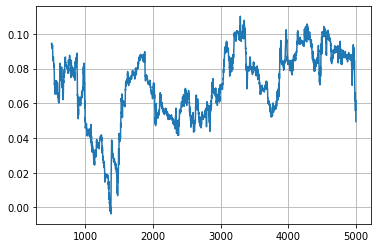

In [39]:
rewards = pd.Series(keep_rewards)
rewards.rolling(500).mean().plot(grid=True)

array([[<AxesSubplot:>, <AxesSubplot:>]], dtype=object)

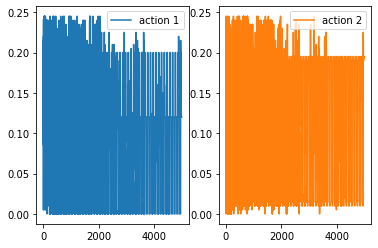

In [41]:
actions_df = pd.DataFrame(keep_actions)
actions_df.columns = ['action 1', 'action 2']
actions_df.plot(subplots=True, layout=(1,2))

<AxesSubplot:>

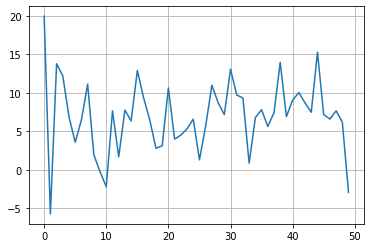

In [42]:
episodic_rewards = pd.Series(keep_episodic_rewards)
episodic_rewards.plot(grid=True)

In [43]:
actions_series = pd.Series(keep_actions)

In [44]:
tmp = actions_series.value_counts()
tmp[tmp>0]

(0.12, 0.195)     1603
(0.0, 0.01)        814
(0.2, 0.19)        803
(0.0, 0.015)       786
(0.095, 0.14)        4
                  ... 
(0.11, 0.045)        1
(0.15, 0.135)        1
(0.07, 0.06)         1
(0.185, 0.235)       1
(0.215, 0.225)       1
Length: 823, dtype: int64

In [45]:
tmp[tmp>2]


(0.12, 0.195)     1603
(0.0, 0.01)        814
(0.2, 0.19)        803
(0.0, 0.015)       786
(0.095, 0.14)        4
(0.245, 0.165)       4
(0.185, 0.12)        4
(0.075, 0.095)       3
(0.025, 0.13)        3
(0.1, 0.125)         3
(0.19, 0.005)        3
(0.13, 0.185)        3
(0.19, 0.165)        3
(0.08, 0.015)        3
(0.225, 0.135)       3
(0.21, 0.165)        3
(0.09, 0.245)        3
(0.01, 0.13)         3
(0.235, 0.135)       3
(0.085, 0.01)        3
(0.02, 0.215)        3
(0.105, 0.215)       3
(0.185, 0.125)       3
dtype: int64